In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/latest-world-news-2025/News_2025.csv


In [2]:
from sklearn.feature_extraction import text
from sklearn.metrics.pairwise import cosine_similarity
import plotly.express as px
import plotly.graph_objects as go

In [3]:
data = pd.read_csv('/kaggle/input/latest-world-news-2025/News_2025.csv')
print(data.head(5))

                                               image  \
0  https://static01.nyt.com/images/2025/06/17/mul...   
1  https://npr.brightspotcdn.com/dims3/default/st...   
2  https://static.toiimg.com/thumb/msid-121947693...   
3  https://www.sciencealert.com/images/2025/06/dr...   
4  https://scx2.b-cdn.net/gfx/news/hires/2025/whe...   

                                               title              source  \
0  At Chile’s Vera Rubin Observatory, Earth’s Lar...  The New York Times   
1  Israel vows to intensify attacks after Iranian...                 NPR   
2  Who is Karen Read? Boston woman acquitted of m...      Times of India   
3  1930s 'Dragon Man' Finally Gives Elusive Ancie...        ScienceAlert   
4  When Earth iced over, early life may have shel...            Phys.org   

                             sourceUrl               publishedAt  \
0              https://www.nytimes.com  2025-06-19T14:53:48.000Z   
1                  https://www.npr.org  2025-06-19T10:32:02.000Z   
2 

In [4]:
data.columns

Index(['image', 'title', 'source', 'sourceUrl', 'publishedAt', 'link'], dtype='object')

In [5]:
# Look at the sources
categories = data["source"].value_counts()
label = categories.index
counts = categories.values
figure = px.bar(data, x=label, 
                y = counts, 
            title="sources of the news")
figure.show()

The Daily Galaxy stands out as the most prominent source, contributing the highest number of news articles.
Other notable contributors include Space.com, Phys.org, and Reuters, each providing a moderate number of articles.
A long tail of sources contributes a relatively smaller number of articles, which indicates a diverse and dispersed set of news providers.
Several well-known global outlets such as ABC News, The Guardian, and NBC News are also present, though their contribution in this dataset is limited compared to The Daily Galaxy.
The dataset seems to have a skewed distribution, where a few sources dominate the content volume.
The presence of many niche or scientific sources (like Phys.org and Space.com) suggests that the dataset might have a focus on science or technology-related topics.



In [6]:
import sklearn.feature_extraction.text
print(dir(sklearn.feature_extraction.text))


['BaseEstimator', 'CountVectorizer', 'ENGLISH_STOP_WORDS', 'FLOAT_DTYPES', 'FeatureHasher', 'HasMethods', 'HashingVectorizer', 'Integral', 'Interval', 'Mapping', 'NotFittedError', 'OneToOneFeatureMixin', 'Real', 'StrOptions', 'TfidfTransformer', 'TfidfVectorizer', 'TransformerMixin', '_IS_32BIT', '_VectorizerMixin', '__all__', '__builtins__', '__cached__', '__doc__', '__file__', '__loader__', '__name__', '__package__', '__spec__', '_analyze', '_check_stop_list', '_document_frequency', '_make_int_array', '_preprocess', 'array', 'check_array', 'check_is_fitted', 'defaultdict', 'itemgetter', 'normalize', 'np', 'partial', 're', 'sp', 'strip_accents_ascii', 'strip_accents_unicode', 'strip_tags', 'unicodedata', 'warnings']


In [7]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity

# Get the list of titles
feature = data['title'].tolist()

# Create the vectorizer
tfidf = TfidfVectorizer(stop_words='english')

# Fit and transform the data
tfidf_matrix = tfidf.fit_transform(feature)

# Compute cosine similarity
similarity = cosine_similarity(tfidf_matrix)


In [8]:
indices = pd.Series(data.index, index=data['title']).drop_duplicates()

In [9]:
def news_topic(title, similarity = similarity):
    index = indices[title]
    similarity_scores = list(enumerate(similarity[index]))
    similarity_scores = sorted(similarity_scores, 
    key=lambda x: x[1], reverse=True)
    similarity_scores = similarity_scores[0:10]
    newsindices = [i[0] for i in similarity_scores]
    return data['title'].iloc[newsindices]

print(news_topic)

<function news_topic at 0x7a25e8f9a520>


In [10]:

feature_names = tfidf.get_feature_names_out()
top_n = 20

# Sum of TF-IDF weights per word
tfidf_sums = tfidf_matrix.sum(axis=0).A1
top_indices = np.argsort(tfidf_sums)[::-1][:top_n]

print(" Top 20 Most Important Words (TF-IDF):")
for idx in top_indices:
    print(f"{feature_names[idx]}: {tfidf_sums[idx]:.2f}")


 Top 20 Most Important Words (TF-IDF):
iran: 4.87
trump: 3.96
new: 3.92
israel: 3.29
earth: 2.75
scientists: 2.62
switch: 2.49
update: 2.27
nasa: 2.24
years: 2.02
apple: 1.99
say: 1.88
attack: 1.80
conflict: 1.79
largest: 1.70
discovery: 1.70
solar: 1.67
galaxy: 1.66
samsung: 1.57
says: 1.54


In [11]:
from sklearn.cluster import KMeans

# Group number
k = 5
model = KMeans(n_clusters=k, random_state=42)
labels = model.fit_predict(tfidf_matrix)

# Add labels to the dataframe
data['cluster'] = labels

for cluster in range(k):
    print(f"\n Cluster {cluster}:")
    print(data[data['cluster'] == cluster]['title'].head(3).to_string(index=False))



 Cluster 0:
At Chile’s Vera Rubin Observatory, Earth’s Larg...
Who is Karen Read? Boston woman acquitted of mu...
1930s 'Dragon Man' Finally Gives Elusive Ancien...

 Cluster 1:
Nearby Sculptor galaxy revealed in ultra-detail...
Samsung Galaxy S24 took its first big step towa...
iPhone 17 Pro launch: After using the iPhone 16...

 Cluster 2:
Israel vows to intensify attacks after Iranian ...
Rwanda and DR Congo agree draft peace deal to e...
What are the risks of bombing Iran's nuclear si...

 Cluster 3:
I Tried the Future of Smart Glasses at WWDC. Th...
Evacuations ordered for wildfires in southwest ...
Finland Makes New Move to Defend Itself From Ru...

 Cluster 4:
         The island city where Juneteenth was born
Why Israel wants US bunker busters to hit Iran’...
NASA Engineers Simulate Lunar Lighting for Arte...


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning



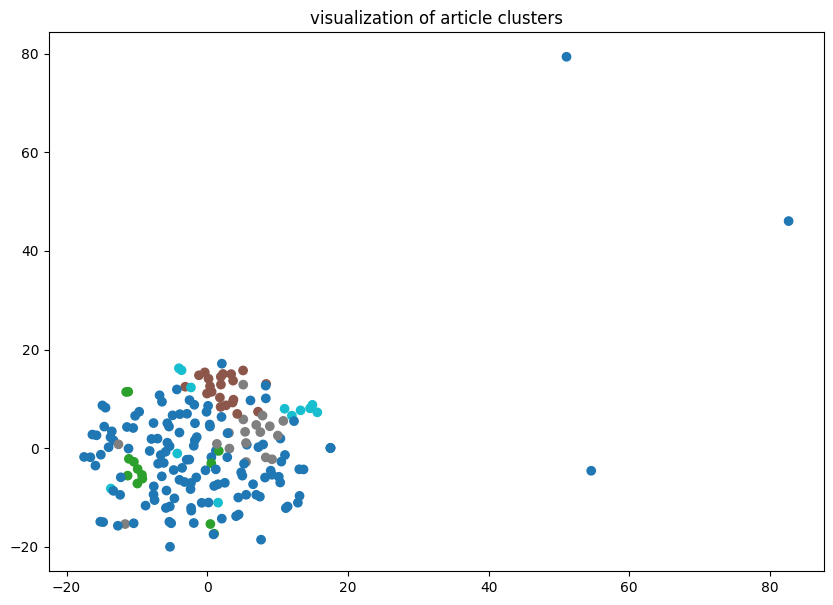

In [12]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

X_reduced = TSNE(n_components=2, perplexity=30, random_state=42).fit_transform(tfidf_matrix.toarray())

plt.figure(figsize=(10, 7))
plt.scatter(X_reduced[:, 0], X_reduced[:, 1], c=data['cluster'], cmap='tab10')
plt.title("visualization of article clusters")
plt.show()
